# U-net implementation with Bioloid Parts

## Juan Sebastián Hernández Reyes 

This notebook will show the adequacy of the U-net architecture in the problem of semantic segmentation for different Bioloid parts, generating the dataset using Blender to generate renders of every part in differents poses, ilumination and conditions, and using Python to merge the renders in the final images and get the labels from every synthetic image
<center>
<div>
<img src="https://raw.githubusercontent.com/juansebashr/BioloidPartDetection/main/Segmentation/carseg.png?token=AGHYYU777LUYTC4UPDIKW2LA2X3I2" style="width:500 ;height:250">
</div>
</center>
<caption><center> <u><b>Figure 1</u></b>: Example of semantic segmentation<br> </center></caption>

This notebook is based in a laboratory of the 4th course of the Deep Learning Specialization for Deeplearning.ai, in Coursera


## U-net architecture

The U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other semantic segmentation tasks. 

U-Net builds on a previous architecture called the Fully Convolutional Network, or FCN, which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. This is necessary because the dense layers destroy spatial information (the "where" of the image), which is an essential part of image segmentation tasks. An added bonus of using transpose convolutions is that the input size no longer needs to be fixed, as it does when dense layers are used. 

Unfortunately, the final feature layer of the FCN suffers from information loss due to downsampling too much. It then becomes difficult to upsample after so much information has been lost, causing an output that looks rough. 

U-Net improves on the FCN, using a somewhat similar design, but differing in some important ways.  Instead of one transposed convolution at the end of the network, it uses a matching number of convolutions for downsampling the input image to a feature map, and transposed convolutions for upsampling those maps back up to the original input image size. It also adds skip connections, to retain information that would otherwise become lost during encoding. Skip connections send information to every upsampling layer in the decoder from the corresponding downsampling layer in the encoder, capturing finer information while also keeping computation low. These help prevent information loss, as well as model overfitting. 

### Model architecture

The architecture from the U-net is presented below 

<center>
<div>
<img src="https://raw.githubusercontent.com/juansebashr/BioloidPartDetection/main/Segmentation/unet.png?token=AGHYYU2FTGWLBCME5T2LCETA2X3A4" width="800">
</div>
</center>

**Contracting path** (Encoder containing downsampling steps):

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 unpadded convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

**Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection. 

**Expanding path** (Decoder containing upsampling steps):

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. You need to perform cropping to handle the loss of border pixels in every convolution.

**Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class. 

The U-Net network has 23 convolutional layers in total. 

<a name='1'></a>
## 1 - Packages

Run the cell below to import all the libraries you'll need:

In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
import os
import numpy as np 
#import pandas as pd 
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

<a name='2'></a>
## 2 - Load and Split the Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "D:\\Documents\\PycharmProjects\\BioloidPartsDetection\\Render_Workspace\\ImageMerging\\Prueba"
path_list = os.listdir(path)
print(path)
image_list = []
mask_list = []

#Here we separate the images from the labels and put them both in a list so we can
#take them easily
for file in path_list:

  if file[-9:] == 'Label.png':
    mask_list.append(os.path.join(path,file))
    continue

  if file[-4:] == '.png':
    image_list.append(os.path.join(path,file))

D:\Documents\PycharmProjects\BioloidPartsDetection\Render_Workspace\ImageMerging\Prueba


### Check out the some of the unmasked and masked images from the dataset:

After you are done exploring, revert back to `N=2`. Otherwise the autograder will throw a `list index out of range` error.

Text(0.5, 1.0, 'Segmentation')

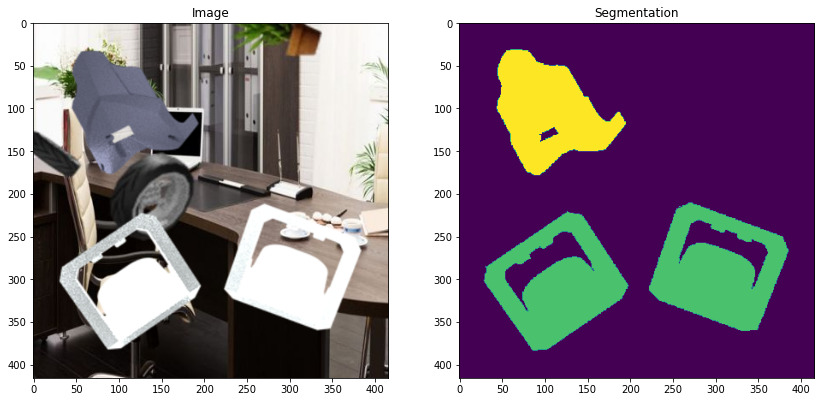

In [ ]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Segmentation')

<a name='2-1'></a>
### 2.1 - Split Your Dataset into Unmasked and Masked Images

In [ ]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'D:\\Documents\\PycharmProjects\\BioloidPartsDetection\\Render_Workspace\\ImageMerging\\Prueba\\image0_1objects.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'D:\\Documents\\PycharmProjects\\BioloidPartsDetection\\Render_Workspace\\ImageMerging\\Prueba\\image0_1objectsLabel.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'D:\\Documents\\PycharmProjects\\BioloidPartsDetection\\Render_Workspace\\ImageMerging\\Prueba\\image0_2objects.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'D:\\Documents\\PycharmProjects\\BioloidPartsDetection\\Render_Workspace\\ImageMerging\\Prueba\\image0_2objectsLabel.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'D:\\Documents\\PycharmProjects\\BioloidPartsDetection\\Render_Workspace\\ImageMerging\\Prueba\\image0_3objects.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'D:\\Documents\\PycharmProjects\\BioloidPartsDetection\\Render_Workspace\\ImageMerging\\Prueba\\image0_3objectsLabel.png'>)


In [ ]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'D:\\Documents\\PycharmProjects\\BioloidPartsDetection\\Render_Workspace\\ImageMerging\\Prueba\\image0_1objects.png', shape=(), dtype=string)
tf.Tensor(b'D:\\Documents\\PycharmProjects\\BioloidPartsDetection\\Render_Workspace\\ImageMerging\\Prueba\\image0_1objectsLabel.png', shape=(), dtype=string)


<a name='2-2'></a>
### 2.2 - Preprocess Your Data

In [ ]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    #mask = mask + 1
    #mask = tf.image.convert_image_dtype(mask, tf.int8)
    #mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    #input_image = input_image / tf.reduce_max(input_image)

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

(96, 128, 3)
(96, 128, 1)


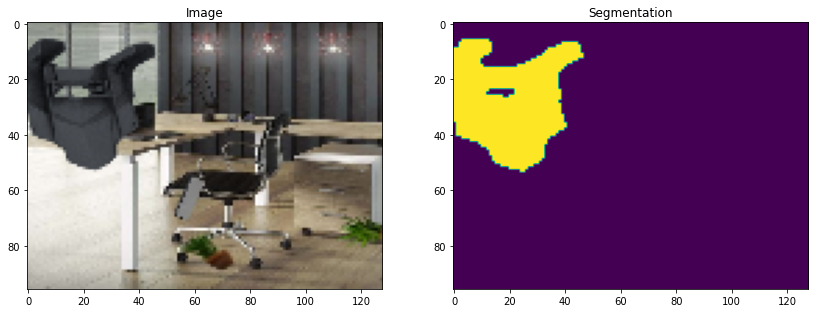

In [ ]:
for data in processed_image_ds.take(1):
  fig, arr = plt.subplots(1, 2, figsize=(14, 10))
  arr[0].imshow(data[0])
  arr[0].set_title('Image')
  arr[1].imshow(data[1])
  print(data[0].shape)
  print(data[1].shape)
  arr[1].set_title('Segmentation')

## 3 - Build the model

We are going to make the U-net first defining the convolutional downsampling block and the convolutional upsampling block and then putting everything together in the model

In [ ]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D()(conv)
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [ ]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)   
    return conv

In [ ]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs, n_filters)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3) # Include a dropout of 0.3 for this layer
    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=None) 
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters*8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

### Set Model Dimensions

In [ ]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

### Check out the model summary below! 

In [ ]:
unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 96, 128, 32)  896         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 96, 128, 32)  9248        conv2d_40[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 48, 64, 32)   0           conv2d_41[0][0]                  
____________________________________________________________________________________________

### Loss Function

In semantic segmentation, you need as many masks as you have object classes. In the dataset you're using, each pixel in every mask has been assigned a single integer probability that it belongs to a certain class, from 0 to num_classes-1. The correct class is the layer with the higher probability. 

This is different from categorical crossentropy, where the labels should be one-hot encoded (just 0s and 1s). Here, you'll use sparse categorical crossentropy as your loss function, to perform pixel-wise multiclass prediction. Sparse categorical crossentropy is more efficient than other loss functions when you're dealing with lots of classes.

In [ ]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Dataset Handling

Below, define a function that allows you to display both an input image, and its ground truth: the true mask. The true mask is what your trained model output is aiming to get as close to as possible. 

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(416, 416, 1)


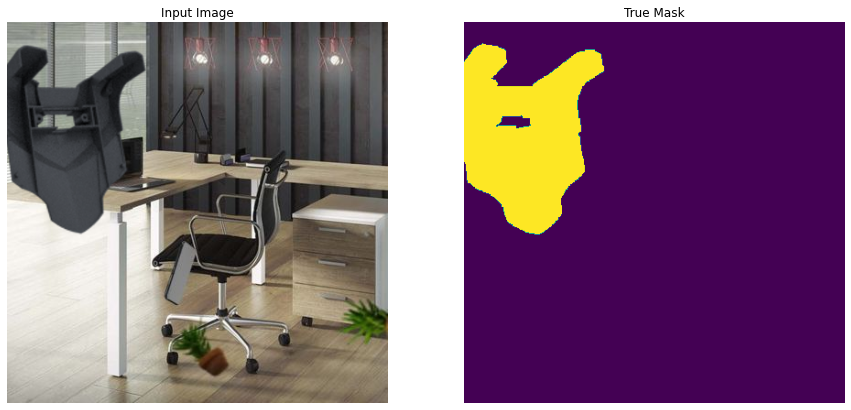

In [ ]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


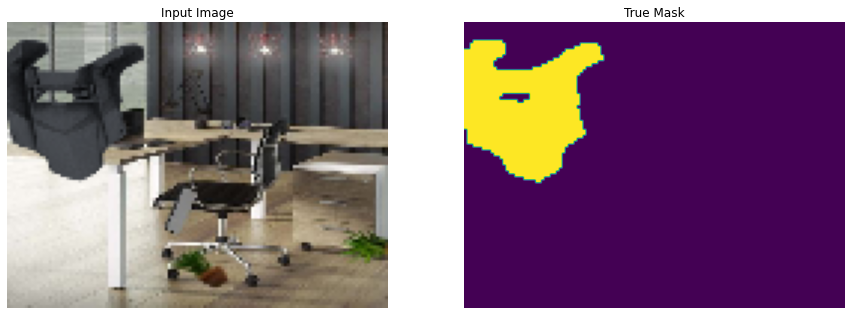

In [ ]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

<a name='4'></a>
## 4 - Train the Model

In [ ]:
#The eopchs tends to be more susceptive to the size of the training dataset, in
#the case of 6000 examples, 10 epochs is more than enough

EPOCHS = 10
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32

processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

model_history = unet.fit(train_dataset, epochs=EPOCHS)

Epoch 1/10
188/188 [==============================] - 25s 130ms/step - loss: 0.0401 - accuracy: 0.9862
Epoch 2/10
188/188 [==============================] - 17s 92ms/step - loss: 0.0652 - accuracy: 0.9795
Epoch 3/10
188/188 [==============================] - 17s 91ms/step - loss: 0.0465 - accuracy: 0.9845
Epoch 4/10
188/188 [==============================] - 17s 92ms/step - loss: 0.0577 - accuracy: 0.9813
Epoch 5/10
188/188 [==============================] - 17s 91ms/step - loss: 0.0355 - accuracy: 0.9878
Epoch 6/10
188/188 [==============================] - 17s 92ms/step - loss: 0.0553 - accuracy: 0.9823
Epoch 7/10
188/188 [==============================] - 17s 90ms/step - loss: 0.0514 - accuracy: 0.9833
Epoch 8/10
188/188 [==============================] - 17s 93ms/step - loss: 0.0416 - accuracy: 0.9857
Epoch 9/10
188/188 [==============================] - 17s 91ms/step - loss: 0.0324 - accuracy: 0.9887
Epoch 10/10
188/188 [==============================] - 17s 92ms/step - loss: 0.03

<a name='4-1'></a>
### 4.1 - Create Predicted Masks 

Now, define a function that uses `tf.argmax` in the axis of the number of classes to return the index with the largest value and merge the prediction into a single image:

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

<a name='4-2'></a>
### 4.2 - Plot Model Accuracy

Let's see how your model did! 

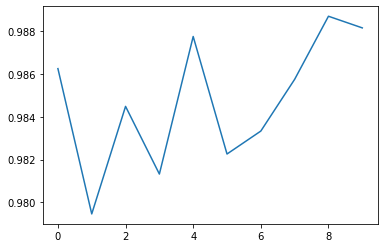

In [ ]:
plt.plot(model_history.history["accuracy"])

<a name='4-3'></a>
### 4.3 - Show Predictions 

Next, check your predicted masks against the true mask and the original input image:

In [ ]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

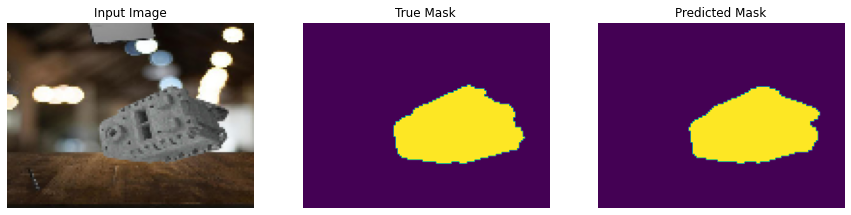

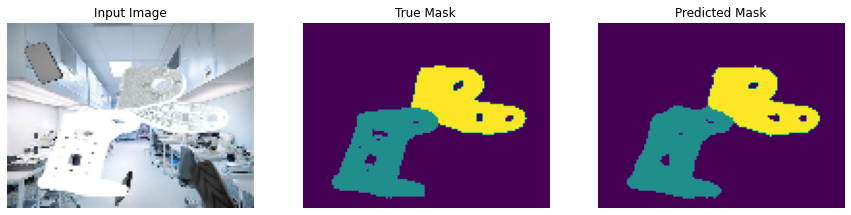

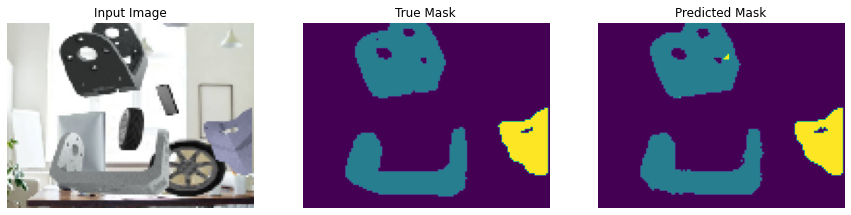

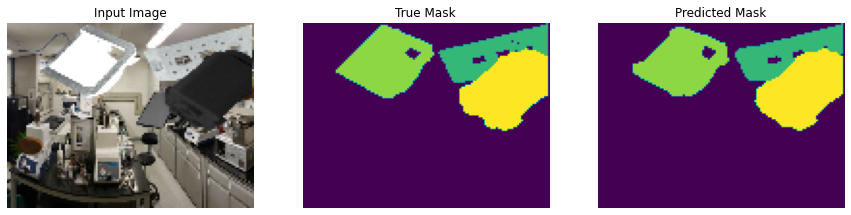

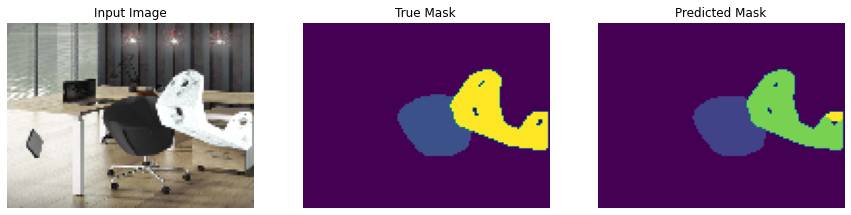

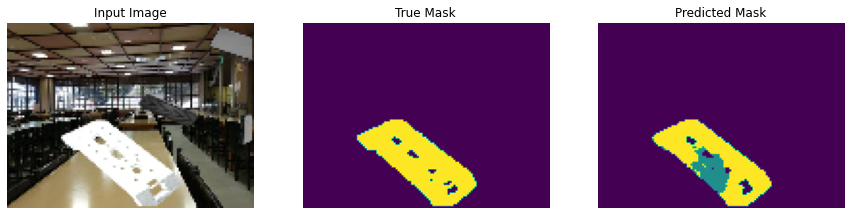

In [ ]:
show_predictions(train_dataset, 6)